# Allocation quality vs. runtime for various configurations

In this notebook, we evaluate the impact of splitting larger optimization problems into smaller sub-problems on policy runtime and quality of solution for max-min fairness policies.

## Import statements and plotting code

In [1]:
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from matplotlib import rc
import numpy as np
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=2, rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
def plot_runtime_vs_metrics(runtimes, metrics,
                            metric_label,
                            yticks,
                            label_locations=None,
                            errorbars=False,
                            xscale_in_log=False):
    plt.figure(figsize=(6.5, 2.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    labels = list(runtimes.keys())
    for label in labels:
        mean_runtimes = []
        mean_metrics = []
        metric_error_bars = []
        runtime_error_bars = []
        for runtime, metric in zip(runtimes[label], metrics[label]):
            mean_runtimes.append(np.mean(runtime))
            mean_metrics.append(np.mean(metric))
            runtime_error_bars.append(np.std(runtime))
            metric_error_bars.append(np.std(metric))
        print(label, mean_runtimes, mean_metrics)
        ax.scatter(mean_runtimes, mean_metrics, label=label)
        if errorbars:
            ax.errorbar(mean_runtimes, mean_metrics, xerr=runtime_error_bars,
                        yerr=metric_error_bars)
        if label_locations is not None:
            ax.annotate(label, label_locations[label])

    if xscale_in_log:
        ax.set_xscale('log')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    if yticks is not None:
        plt.ylim(0, ymax*1.15)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    ax.set_ylabel(metric_label)
    ax.set_xlabel("Runtime (seconds)")
    if yticks is not None:
        ax.set_yticks(yticks)
    sns.despine()
            
    plt.show()

In [3]:
def plot_metrics_vs_num_sub_problems(metrics,
                                     metric_label,
                                     xticks,
                                     yticks):
    plt.figure(figsize=(6.5, 2.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    labels = list(metrics.keys())
    all_num_sub_problems = []
    all_metrics = []
    for label in labels:
        mean_metrics = []
        metric_error_bars = []
        num_sub_problems = 1
        if label.startswith("POP-"):
            num_sub_problems = int(label.split("POP-")[1].strip())
        for metric in metrics[label]:
            mean_metrics.append(np.mean(metric))
            metric_error_bars.append(np.std(metric))
        all_num_sub_problems.append(num_sub_problems)
        all_metrics.append(mean_metrics[-1])
    ax.plot(all_num_sub_problems, all_metrics, marker='o')

    ax.set_ylabel(metric_label)
    ax.set_xlabel("Number of sub-problems")
    if yticks is not None:
        ax.set_yticks(yticks)
    sns.despine()
            
    plt.show()

## Plot runtime vs. allocation quality and allocation quality vs. number of sub-problems

In [4]:
def parse_values(filename):
    parsed_values = {}
    skip_line = True
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            line_tokens = line.split('\t')
            
            # Skip first line (header).
            if skip_line:
                skip_line = False
                continue

            [v100s, p100s, k80s, policy, k, seed, num_jobs_or_lambda,
             objective_value, runtime] = line_tokens
            system_name = "POP-%s" % k
            num_jobs_or_lambda = float(num_jobs_or_lambda)
            seed = int(seed)
            try:
                runtime = float(runtime)
                objective_value = float(objective_value)
            except:
                continue
            if num_jobs_or_lambda not in parsed_values:
                parsed_values[num_jobs_or_lambda] = {}
            if system_name not in parsed_values[num_jobs_or_lambda]:
                parsed_values[num_jobs_or_lambda][system_name] = []
            parsed_values[num_jobs_or_lambda][system_name].append(
                (seed, runtime, objective_value))
    runtimes = {}
    objective_values = {}
    for x in parsed_values:
        for y in parsed_values[x]:
            if y not in runtimes:
                runtimes[y] = []
                objective_values[y] = []
            runtimes[y].append([z[1] for z in parsed_values[x][y]])
            objective_values[y].append([z[2] for z in parsed_values[x][y]])
    return runtimes, objective_values

Policy: max_min_fairness_packed
POP-1 [1.269] [28.871]
POP-2 [0.443] [28.765]
POP-4 [0.185] [27.86]
POP-8 [0.117] [28.809]


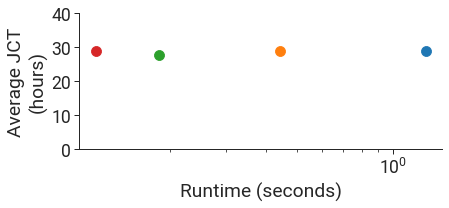

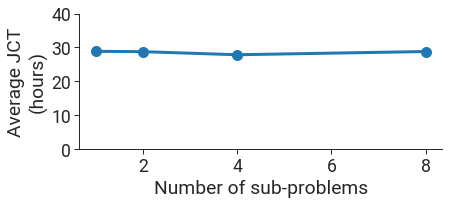

Policy: min_total_duration_perf
POP-1 [0.158] [255.021445]
POP-2 [0.114] [255.98896194444444]
POP-4 [0.113] [256.86090194444444]
POP-8 [0.097] [270.6964538888889]


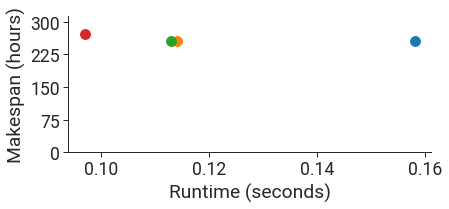

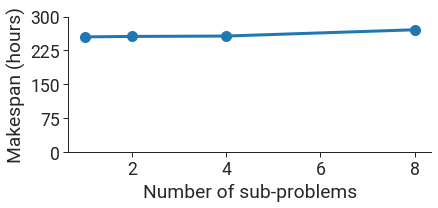

In [5]:
policies = ["max_min_fairness_packed", "min_total_duration_perf"]
ylabels = ["Average JCT\n(hours)", "Makespan (hours)"]
all_yticks = [[0, 10, 20, 30, 40], [0, 75, 150, 225, 300]]
xscale_in_logs = [True, False]
for (policy, ylabel, yticks, xscale_in_log) in zip(
    policies, ylabels, all_yticks, xscale_in_logs):
    print("Policy: %s" % policy)
    runtimes, objective_values = parse_values("logs/%s.tsv" % policy)
    # Use label_locations argument to annotate this scatterplot.
    plot_runtime_vs_metrics(
        runtimes, objective_values,
        ylabel,
        yticks,
        xscale_in_log=xscale_in_log)
    plot_metrics_vs_num_sub_problems(
        objective_values,
        ylabel,
        [1, 2, 4, 8],
        yticks)